# Final Project: Game Review Sentiment Analysis Over Time
## Research Question: 
* Can we use sentiment analysis score to predict the active user base for video games over time

## Dataset: 
* Game Review: twitter/reddit/discord/steam reviews
* active user base: steam

## Algorithm: 
* Baseline(logistic Regression); 
* Transformer(Elmo/Bert)


In [1]:
# Library Loads and Imports

# Load in some of basic libraries.
#import os
#import sys
import io
import re
import string
from time import time
from datetime import datetime
#import pickle

# Load in the scientific libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing with nltk
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer

# Import sklearn libraries for Bag of Words (BOW) and XGBoost
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

# Import tensorflow and associated libraries for layers and building up the
# LSTM and CNN models.
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Flatten, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Tensorflow hub for BERT
import tensorflow_hub as hub
import tensorflow_datasets as tfds

In [2]:
# Libraries to install and then import. These are for different models but include 
# use for the RoBERTa and T5 models.
!pip install unidecode
!pip install transformers
!pip install simpletransformers

In [3]:
# Import the libraries that had dependencies on being installed.
import unidecode

# Huggingface libraries for T5/RoBERTa work
from transformers import T5Config, TFT5Model, T5Tokenizer, TFT5ForConditionalGeneration
from transformers import RobertaConfig, RobertaTokenizerFast, TFRobertaModel, TFRobertaForSequenceClassification
from transformers import glue_convert_examples_to_features
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification, TFAutoModelForSequenceClassification 

In [4]:
""" Download Data: There are 4 games with review data
Fall Guys (fg)
PlayerUnknown Battlegrounds (pubg)
Dota 2 (dota2)
Counterstrike Source: Go (csgo)

Review data has the following columns:
app: ID for the game
useful: how many users voted the review as useful
funny: how many users voted the review as funny
username: username of the person who wrote the review
games_owned: how many games the reviewer owns on Steam
num_reviews: how many reviews the reviewer has written on Steam
recommend: 1 for recommend (thumbs up), -1 for do not recommend (thumbs down)
hours_played: number of hours the reviewer played before writing the review
date: date review was written
text: text of the review
"""
#Fall Guys
fg_url = 'https://raw.githubusercontent.com/susandong/w266_final_project_game_sentiment/master/data/fallguys_reviews.csv'
fg_df = pd.read_csv(fg_url, error_bad_lines=False)
fg_df = fg_df.dropna()

#CS: Go
csgo_url = 'https://raw.githubusercontent.com/susandong/w266_final_project_game_sentiment/master/data/csgo_reviews.csv'
csgo_df = pd.read_csv(csgo_url, error_bad_lines=False)
csgo_df = csgo_df.dropna()

#PUBG
pubg_url = 'https://raw.githubusercontent.com/susandong/w266_final_project_game_sentiment/master/data/pubg_reviews.csv'
pubg_df = pd.read_csv(pubg_url, error_bad_lines=False)
pubg_df = pubg_df.dropna()

#dota2_url = 'https://raw.githubusercontent.com/susandong/w266_final_project_game_sentiment/master/data/dota2_reviews.csv'
#dota2_df = pd.read_csv(dota2_url, error_bad_lines=False)
#player_url = 'https://raw.githubusercontent.com/susandong/w266_final_project_game_sentiment/master/data/PlayerCountData.csv'
#player_df = pd.read_csv(player_url, error_bad_lines=False)

In [5]:
# Data Preprocessing
nltk.download('stopwords')

tknzr = TweetTokenizer()
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
#lemma = WordNetLemmatizer()

# Convert accented characters
def remove_accents(text):
  try:
    text = unidecode.unidecode(text)
  except:
    pass
  return text

# Remove digits and punctuation
def remove_nonletters(text):
  try:
    #Remove digits AND punctuation
    text = re.sub('[^a-zA-Z]', ' ', text)
    
    # Remove just digits that are by themselves
    #text = re.sub('^\d+\s|\s\d+\s|\s\d+$', ' ', text)
  except:
    pass
  return text


# Use Tweet Tokenizer for some built-in emoji support
def tweet_tokenization(text):
  try:
    return tknzr.tokenize(text)
  except:
    pass

def remove_stopwords(token):
  try:
    return [item for item in token if item not in stop_words]
  except:
    pass

def remove_stemmer(token):
  try:
    return [stemmer.stem(i) for i in token]
  except:
    pass

def remove_lemmatizer(token):
  try:
    return [lemma.lemmatize(word=w, pow='v') for w in token]
  except:
    pass
  
def remove_shortwords(token):
  try:
    return [i for i in token if len(i) > 1]
  except:
    pass

def token_to_string(listTokens):
  return ' '.join(listTokens)

# Process text from dataframe. df = dataframe to clean, text = name of column with text
def process_text(df, text):  
  #Create new column for cleaned text
  df['cleaned'] = df[text]

  # Lower case all text
  df['cleaned'] = df['cleaned'].str.lower()

  # Clean URLs
  df['cleaned'] = df['cleaned'].str.replace('http\S+|www.\S+', '', case=False)

  # Remove accents from text
  #df['cleaned'] = df['cleaned'].apply(remove_accents)

  # Remove numbers and punctuation from text
  df['cleaned'] = df['cleaned'].apply(remove_nonletters)
  
  # Tokenize
  df['cleaned'] = df['cleaned'].apply(tweet_tokenization)

  # Remove stopwords
  #df['cleaned'] = df['cleaned'].apply(remove_stopwords)
  
  # Remove short words
  df['cleaned'] = df['cleaned'].apply(remove_shortwords)

  # Stemming - can decide to use or not
  #df['cleaned'] = df['cleaned'].apply(remove_stemmer)

  # Convert tokens back to string
  df['cleaned'] = df['cleaned'].apply(token_to_string)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
# preprocess all the datasets for all 3 games
process_text(fg_df, 'text')
#len(fg_df['cleaned'][11]) < 2
process_text(csgo_df, 'text')
process_text(pubg_df, 'text')

In [7]:
# Look at the fall guys processed dataframe
fg_df

,app,useful,funny,username,games_owned,num_reviews,recommend,hours_played,date,text,cleaned
0,1097150,0,0,7.65612E+16,51,16,1,17.1,"11 October, 2020",ow i fell:( thats a sad face btwincase you did...,ow fell thats sad face btwincase you didnt kno...
1,1097150,0,0,7.65612E+16,1,1,1,50.4,"11 October, 2020",yes,yes
2,1097150,0,0,7.65612E+16,64,3,-1,8.1,"11 October, 2020",This Game is not fun. If your looking for a ga...,this game is not fun if your looking for game ...
3,1097150,0,0,floolp,1,1,1,15.3,"11 October, 2020",Fun but VERY HARD game!this is a very fun game...,fun but very hard game this is very fun game y...
4,1097150,0,0,7.65612E+16,6,1,1,34.9,"11 October, 2020",its fun,its fun
...,...,...,...,...,...,...,...,...,...,...,...
90653,1097150,3,0,7.65612E+16,0,1,-1,2.7,"8 September, 2020",A TOTAL GARBAGE!!i wish i never bought it and ...,total garbage wish never bought it and now wan...
90654,1097150,0,0,quazwaz,15,6,1,16.5,"8 September, 2020",this game is so simple my mom likes it 10/10,this game is so simple my mom likes it
90655,1097150,1,0,Elbourne,407,1,-1,18.7,"8 September, 2020","ruined by hackers and refused a refund, avoid.",ruined by hackers and refused refund avoid
90656,1097150,0,0,7.65612E+16,8,1,1,14.7,"8 September, 2020",very good game and fun to play,very good game and fun to play


In [8]:
# Concatenate all 3 games data to one large dataset
all_df = pd.concat([fg_df,csgo_df,pubg_df])
all_clean_df = all_df[["recommend","cleaned"]]

In [9]:
# Method to remove blank rows in our data due to missing data.
# Use a tokenizer from nltk for the Regex tokens in our data.
def remove_blankrow(df,column):
  tokenizer = RegexpTokenizer(r'\w+')
  df['lens'] = [len(tokenizer.tokenize(utterance)) for utterance in df[column]]
  df_clean = df[df['lens'] != 0]
  return df_clean

In [10]:
# Final, cleaned, and combined data set.
df_final = remove_blankrow(all_clean_df,'cleaned')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [11]:
df_final.shape

(433197, 3)

In [12]:
all_clean_df.shape

(452858, 3)

In [13]:
# Check the length of reviews
print(df_final.lens.describe())
print(df_final['lens'].quantile(0.90))

# Remove the extremely long reviews - those longer than 90% of all reviews.
df_final=df_final[df_final.lens<(df_final['lens'].quantile(0.90))]

count    433197.000000
mean         24.593351
std          60.585161
min           1.000000
25%           2.000000
50%           6.000000
75%          21.000000
max        2667.000000
Name: lens, dtype: float64
60.0


In [14]:
# Check positive data vs negative data
# I.E. those that recommend a game vs those that do not.
df_final.recommend.value_counts()

 1    296086
-1     93586
Name: recommend, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


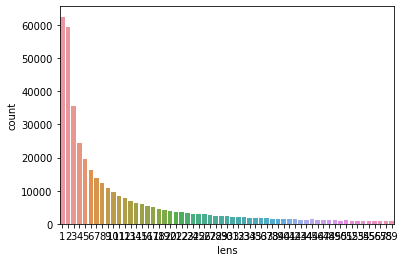

In [15]:
# Plot out the length of the reviews by the number of them.
sns.countplot(df_final.lens)

In [16]:
# Use the resample library to balance the positive reviews from the negative.
# This prevents highly skewed reviews to avoid affecting the training sets.

df_majority = df_final[df_final.recommend==1]
df_minority = df_final[df_final.recommend==-1]

df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=296086,    # to match majority class
                                 random_state=235) # reproducible results
 
# Combine majority class with upsampled minority class
df_balanced = pd.concat([df_majority, df_minority_upsampled])
 

# Replace outcome label -1 with 0
df_balanced['recommend'] = df_balanced['recommend'].replace([-1],0)

# Display new class counts
df_balanced.recommend.value_counts()

1    296086
0    296086
Name: recommend, dtype: int64

In [17]:
# Use the train_test_split library to split out into train and test: 80% to train and 20% to test.
X_train, X_test, y_train, y_test = train_test_split(df_balanced.cleaned,df_balanced.recommend, 
                                                    test_size = 0.2, 
                                                    stratify=df_balanced.recommend)

In [18]:
# #Bag of Words + XGBoost
# from sklearn.feature_extraction.text import CountVectorizer
# import xgboost as xgb
# from sklearn.model_selection import cross_val_score
# from sklearn.metrics import confusion_matrix
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import accuracy_score

In [19]:
# Flag to run all models (used if needing to rebuild environment often)
RUN_ALL_MODELS = True

In [20]:
# Our first model will be a basic Bag of Words.
vectorizer = CountVectorizer(analyzer = "word", max_features=1500, min_df=.01, max_df=0.7) 
bow_train = vectorizer.fit_transform(X_train).toarray()

In [21]:
# Set up the XGB classifier
if RUN_ALL_MODELS:
    BOW_XGB = xgb.XGBClassifier(max_depth=7, n_estimators=300, objective="binary:logistic", 
                                random_state=1, tree_method='gpu_hist', predictor='gpu_predictor')

    BOW_XGB_scores = cross_val_score(BOW_XGB, bow_train, y_train, cv=3, n_jobs=-1)

    print("Averaged CV Accuracy: %0.5f" % BOW_XGB_scores.mean())

    # Fit and predict
    BOW_XGB.fit(bow_train, y_train)
    bow_test = (vectorizer.transform(X_test)).toarray()
    XGB_pred = BOW_XGB.predict(bow_test)

Averaged CV Accuracy: nan


XGBoostError: ignored

In [22]:
# Get scores of the BOW and XGB models.
if RUN_ALL_MODELS:
    BOW_XGB_scores_test = cross_val_score(BOW_XGB, bow_test, y_test, cv=3, n_jobs=-1)
    print("Averaged CV Accuracy: %0.5f (+/- %0.5f)" % (BOW_XGB_scores_test.mean(), BOW_XGB_scores_test.std() * 2))

NameError: ignored

In [23]:
# # LSTM
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# from keras.preprocessing.sequence import pad_sequences
# from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
# from keras.layers import Bidirectional, GlobalMaxPool1D
# from keras.models import Model
# from keras import initializers, regularizers, constraints, optimizers, layers

In [24]:
# Set up initial parameters for the LSTM model.
max_features = 200000  # Only consider the top 200k words
maxlen = 60
embedding_dim = 128

In [25]:
# from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
# from tensorflow.keras import layers
# import string
# import re

# Create vectorization layers that adapt the training values.
vectorization_layer = TextVectorization(max_tokens=max_features,
    output_mode='int',
    output_sequence_length=maxlen)

vectorization_layer.adapt(X_train.values)
vectorization_layer.adapt(X_test.values)

In [26]:
# Build the baseline CNN model. This will be our "stancdard" model that we base performances off of.
def CNN_model():
    # Build up the model by additive layers - works due to being a sequential model.
    model = tf.keras.models.Sequential()
    model.add(tf.keras.Input(shape=(None,), dtype=tf.string))
    model.add(vectorization_layer)
    model.add(layers.Embedding(max_features, embedding_dim))
    model.layers[1].trainable = False

    # Add in the 1-d convolutional layer.
    model.add(tf.keras.layers.Conv1D(
        filters=5,
        kernel_size=3, 
        strides=1, 
        padding='same', 
        activation='relu', 
        use_bias=True, 
        kernel_initializer='glorot_uniform', 
        bias_initializer='zeros')
    )    

    model.add(layers.GlobalAveragePooling1D())
    model.add(layers.Dense(64, activation="relu"))
    #model.add(layers.Dropout(0.05))            # May not need this to optimize.
    model.add(layers.Dense(1, activation="sigmoid"))

    model.summary()   

    model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(), metrics="accuracy")
    return model

In [27]:
# Train the CNN model
if RUN_ALL_MODELS:
    cnn_model = CNN_model()
    history = cnn_model.fit(X_train, 
                            y_train,
                            validation_data=(X_test, y_test),
                            epochs=10,
                            batch_size=128)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 60)                0         
_________________________________________________________________
embedding (Embedding)        (None, 60, 128)           25600000  
_________________________________________________________________
conv1d (Conv1D)              (None, 60, 5)             1925      
_________________________________________________________________
global_average_pooling1d (Gl (None, 5)                 0         
_________________________________________________________________
dense (Dense)                (None, 64)                384       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 25,602,374
Trainable params: 2,374
Non-trainable params: 25,600,000
________________________________________

In [28]:
# Build the bi-directional LSTM
def LSTM_model():
    # Take in an integer input for vocab indices.
    model = tf.keras.models.Sequential()  
    model.add(tf.keras.Input(shape=(None,), dtype=tf.string))

    # Next, we add a layer to map those vocab indices into a space of dimensionality
    # 'embedding_dim'.
    model.add(vectorization_layer)
    model.add(tf.keras.layers.Embedding(max_features, embedding_dim))
    model.layers[1].trainable = False

    # Add bidirectional LSTM.
    model.add(tf.keras.layers.LSTM(60, return_sequences=True,name='lstm'))
    model.add(tf.keras.layers.GlobalMaxPool1D())
    model.add(tf.keras.layers.Dropout(0.1))
    model.add(tf.keras.layers.Dense(50,activation="relu"))
    model.add(tf.keras.layers.Dropout(0.1))

    # Add a classifier
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

    model.summary()
    model.compile("adam", "binary_crossentropy", metrics=["accuracy"])

    return model

In [29]:
# Train LSTM
if RUN_ALL_MODELS:
    model_LSTM = LSTM_model()
    model_LSTM.fit(np.array(X_train),
                   y_train, 
                   validation_data=(X_test, y_test),
                   epochs=20,
                   batch_size=128)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 60)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 60, 128)           25600000  
_________________________________________________________________
lstm (LSTM)                  (None, 60, 60)            45360     
_________________________________________________________________
global_max_pooling1d (Global (None, 60)                0         
_________________________________________________________________
dropout (Dropout)            (None, 60)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)               

KeyboardInterrupt: ignored

In [30]:
# Set up tensorflow config and debugging options.
tf.config.set_soft_device_placement(True)
tf.debugging.set_log_device_placement(True)

In [31]:
# Split off the data into TensorSliceDatasets to use with the tf library.
train,test= train_test_split(df_balanced, test_size=0.2)

In [32]:
# Build the BERT Model with tf_hub.
# Set the embeddings and allow for eager execution.
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"

#tf.enable_eager_execution()
tf.compat.v1.enable_eager_execution() # Updated version

In [33]:
# Convert pandas dataframe to tensorflow dataset
# Note that this specifies the type of each data.
train_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(train["cleaned"].values, tf.string),
            tf.cast(train['recommend'].values, tf.int32)
        )
    )
)

test_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(test["cleaned"].values, tf.string),
            tf.cast(test['recommend'].values, tf.int32)
        )
    )
)

In [42]:
# Build the BERT model by adding in layers similar to the CNN and LSTM.
# Start with the hub layer which specifies higher level model paramters.
hub_layer = hub.KerasLayer(embedding, 
                           input_shape=[], 
                           dtype=tf.string,
                           trainable=True)

# Define the BERT model.
def BERT_model():
    model = tf.keras.Sequential()
    model.add(hub_layer)
    model.add(tf.keras.layers.Dropout(0.1))
    model.add(tf.keras.layers.Dense(16, activation='relu'))
    model.add(tf.keras.layers.Dense(1))

    model.summary()
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                    metrics=['accuracy'])
    
    return model

INFO:absl:resolver HttpCompressedFileResolver does not support the provided handle.
INFO:absl:resolver GcsCompressedFileResolver does not support the provided handle.


In [44]:
# Run the model.
if RUN_ALL_MODELS:
    bert_model = BERT_model()
    print(type(bert_model))
    history = bert_model.fit(train_dataset.shuffle(10000).batch(512),
                             epochs=20,
                             validation_data=test_dataset.batch(512),
                             verbose=1)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   (None, 50)                48190600  
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 16)                816       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 17        
Total params: 48,191,433
Trainable params: 48,191,433
Non-trainable params: 0
_________________________________________________________________
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
Epoch 1/20
 11/926 [..............................] - ETA: 6:57 - loss: 0.6946 - accuracy: 0.4993

KeyboardInterrupt: ignored

In [39]:
 # Set up some different formats for our training data.
# This allows them to be purely string or int arrays.
train_x = train['cleaned'].values
train_y = train['recommend'].values
test_x = test['cleaned'].values
test_y = test['recommend'].values

# Change data into lists to pass into T5/RoBERTa.
tr_x = train_x.tolist()
tr_y = train_y.tolist()
ts_x = test_x.tolist()
ts_y = test_y.tolist()

In [40]:
#####
# TF T5/Roberta Model
#####

references = """
References for T5 investigation:
https://blog.tensorflow.org/2019/11/hugging-face-state-of-art-natural.html
https://www.tensorflow.org/api_docs/python/tf/keras/Model

Test Approach - example from documentation doesn't even work (https://huggingface.co/transformers/model_doc/t5.html#training) 
Creates a known issue with no resolution (https://github.com/tensorflow/tensorflow/issues/41731)

Needs to be converted into a dataframe that has prefixes added on.
See here: https://pypi.org/project/simpletransformers/#t5-transformer 
And here: https://towardsdatascience.com/the-guide-to-multi-tasking-with-the-t5-transformer-90c70a08837b 


References for RoBERTa investigation:
https://huggingface.co/transformers/model_doc/roberta.html#tfrobertamodel
See here: https://towardsdatascience.com/discover-the-sentiment-of-reddit-subgroup-using-roberta-model-10ab9a8271b8
Use Pipeline for convenience - from here: https://huggingface.co/transformers/quicktour.html
    - Can run on smaller inputs, not large datasets (at least with current resources)
"""

In [ ]:
# # Can't run all data - set a limit
# data_len = 100000       # train = 470,000; test = 118,000

# # Start with the model and tokenizer
# t5_size = 't5-small'
# t5_tokenizer = T5Tokenizer.from_pretrained(t5_size)
# # t5_model = TFT5Model.from_pretrained(t5_size)

In [ ]:
# # Test Approach - example from documentation doesn't even work (https://huggingface.co/transformers/model_doc/t5.html#training) 
# # Creates a known issue with no resolution (https://github.com/tensorflow/tensorflow/issues/41731)

# input_ids = t5_tokenizer('The <extra_id_0> walks in <extra_id_1> park', return_tensors='pt').input_ids
# labels = t5_tokenizer('<extra_id_0> cute dog <extra_id_1> the <extra_id_2>', return_tensors='pt').input_ids

# # the forward function automatically creates the correct decoder_input_ids
# loss = t5_model(input_ids=input_ids, labels=labels, return_dict=True)

In [ ]:
# def T5_model():
#     # Need to update for the T5 model.
#     model = TFT5Model.from_pretrained(t5_size)
#     model.compile(optimizer= tf.keras.optimizers.Adam(), 
#                   loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
#                   metrics=['accuracy'])
    
#     model.summary()
#     return model

# t5_model = T5_model()
# history  = t5_model.fit(x=tr_x[:data_len],
#              y=tr_y[:data_len],
#              validation_data=([ts_x[:data_len], ts_y[:data_len]]),
#              batch_size=16,
#              epochs=1)

In [ ]:
# # Based on approach described here for summarization: https://huggingface.co/transformers/task_summary.html 
# from transformers import TFAutoModelWithLMHead, AutoTokenizer
# import tensorflow_datasets
# from transformers import glue_convert_examples_to_features

# model = TFAutoModelWithLMHead.from_pretrained("t5-base", return_dict=True)
# tokenizer = AutoTokenizer.from_pretrained("t5-base")

# inputs = tokenizer.encode("SST2: " + ex_sent, return_tensors="tf", max_length=512)
# outputs = model.generate(inputs, max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)

# tft5_model = TFT5Model.from_pretrained(t5_size)
# tft5_tokenizer = T5Tokenizer.from_pretrained('t5-small')

# train_dataset = data["train"]
# train_dataset = glue_convert_examples_to_features(train_dataset, tft5_tokenizer, 128, 'sst-2')

# print(train_dataset)

# optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0)
# loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# tft5_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# tft5_history = tft5_model.fit(
#  tf_train_dataset, 
#  epochs=2, 
#  steps_per_epoch=100, 
#  validation_data=tf_validation_dataset, 
#  validation_steps=7
# )

In [ ]:
# W266 T5 Approach

# def T5_Keras_model():
#     model = tf.keras.Sequential()
#     model.add(hub_layer)
#     model.add(tf.keras.layers.Dropout(0.1))
#     model.add(tf.keras.layers.Dense(16, activation='relu'))
#     model.add(tf.keras.layers.Dense(1))

#   model.summary()
#   model.compile(optimizer= tf.keras.optimizers.Adam(),
#                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#                 metrics=['accuracy'])

#     encode_in    = tf.keras.layers.Input(shape=(max_len,), dtype='int32', name="encode_in_ids")
#     enc_mask_in  = tf.keras.layers.Input(shape=(max_len,), dtype='int32', name="enc_mask_in_ids")
#     decode_in    = tf.keras.layers.Input(shape=(None,), dtype='int32', name="decode_in_ids")
#     dec_mask_in  = tf.keras.layers.Input(shape=(None,), dtype='int32', name="dec_mask_in_ids")
    
#     t5_layer = TFT5ForConditionalGeneration.from_pretrained(t5_model)
    
#     t5_out = t5_layer({'input_ids': encode_in, 
#                        'decoder_input_ids':decode_in, 
#                        'attention_mask':enc_mask_in,
#                        'decoder_attention_mask':dec_mask_in
#                       }, 
#                              return_dict=True)
    
#     pred_logits = t5_out['logits']
    
#     model = tf.keras.models.Model(inputs=[encode_in, 
#                                           enc_mask_in, 
#                                           decode_in,
#                                           dec_mask_in
#                                          ], 
#                                   outputs=pred_logits)

#     model.compile(loss=t5_custom_loss, 
#                   optimizer=tf.keras.optimizers.Adam(), 
#                   metrics="accuracy")
    
    
#     model.summary()
    
#     return model

In [ ]:
# t5_keras = T5_Keras_model()

In [ ]:
# cut_off = 25000000
#t5_keras.fit(train_dataset,test_dataset)

In [ ]:
# T5 - copied via pytorch approach and attempting modification based on that.

In [ ]:
# from simpletransformers.t5 import T5Model

# model_args = {
#     "max_seq_length": 256,
#     "train_batch_size": 16,
#     "eval_batch_size": 64,
#     "num_train_epochs": 1,
#     "evaluate_during_training": True,
#     "evaluate_during_training_steps": 15000,
#     "evaluate_during_training_verbose": True,
    
#     "use_multiprocessing": False,
#     "fp16": False,

#     "save_steps": -1,
#     "save_eval_checkpoints": False,
#     "save_model_every_epoch": False,

#     "reprocess_input_data": True,
#     "overwrite_output_dir": True,
# }

# t5_model = T5Model("t5-base", args=model_args)

In [ ]:
# Needs to be converted into a dataframe that has prefixes added on.
# See here: https://pypi.org/project/simpletransformers/#t5-transformer 
# And here: https://towardsdatascience.com/the-guide-to-multi-tasking-with-the-t5-transformer-90c70a08837b 

# model.train_model(train_dataset, eval_data=test_dataset)

In [ ]:
# tf_rb_config    = RobertaConfig.from_pretrained('roberta-base')
# tf_rb_model     = TFRobertaModel(tf_rb_config)
# tf_rb_tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')

In [ ]:
# def TF_RoBERTa_model():
#     # Need to update for the T5 model.
#     model = TFRobertaModel(tf_rb_config)
#     model.compile(optimizer= tf.keras.optimizers.Adam(), 
#                   loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
#                   metrics=['accuracy'])
    

#     model.build((data_len,1))
#     model.summary()
#     return model

In [ ]:
#ids = tf_rb_tokenizer.encode(text=tr_x[:data_len], is_split_into_words=True, max_length=512, add_special_tokens=True, padding=True, truncation=True)

In [ ]:
# Issue with building model - need to use 'build' if layers don't support floats, need to try via 'call'
#tf_rb_model = TF_RoBERTa_model()
#history  = tf_rb_model.fit(train_dataset, validation_data=test_dataset, batch_size=16, epochs=1)

In [ ]:
# model_name = 'roberta-base'
# model = TFAutoModelForSequenceClassification.from_pretrained(model_name)
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# classifier = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)


In [ ]:
# # Session keeps crashing due to memory issues.
# results = classifier(tr_x[:50000])
# res_avg = []

# for result in results:
#     res_avg += result['score']